# TP2: Filter Banks

By Daniel Jorge Deutsch, Kevin Kühl and Brayam Santiago Velandia (03/10/2020)

In [24]:
import os
import struct
import sys
import time
import warnings
import wave
from copy import deepcopy
from math import ceil
import packages.wtt as wtt 

import pywt

warnings.filterwarnings("ignore")
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyaudio
from scipy import signal as sig
from scipy.io import wavfile
from scipy.linalg import hankel, inv, norm


In [14]:
class Base:

    def __init__(self, name, tdata=None, freq=None, mag=None):

        if not ((tdata is None) ^ (freq is None or mag is None)):
            raise Exception("You must provide a tdata or a freq and mag arrays")
        if not(freq is None or mag is None):
            if len(freq) != len(mag):
                raise Exception("freq and mag arrays must be of the same length")
        
        self.name = name

        # Time domain attributes
        if not(tdata is None):
            self.tdata = np.asarray(tdata)
        else:
            self.tdata = np.fft.ifft(mag)

        # Frequency domain attributes
        if not(freq is None or mag is None):
            self.freq = np.asarray(freq)
            self.mag = np.asarray(mag)
        else:
            len_fft = 4096                                                           # Length of the transformed axis of the output
            self.freq, self.mag = sig.freqz(self.tdata, worN=len_fft, whole=True)    # Obtains the frequency and magnitude
            self.freq = self.freq/(2*np.pi)                                          # Converts the frequency to (rad/sample)/2π

    
    #------------------------------#
    #--- SAMPLES ------------------#
    #------------------------------#

    def step_split_sample(self, step):
        tdatas = [self.tdata[i::step] for i in range(step)]
        max_len = max([len(tdata) for tdata in tdatas])
        for i, tdata in enumerate(tdatas):
            if len(tdata) != max_len:
                tdatas[i] = np.append(tdata, 0)
            tdatas[i] = self.__class__(f"{self.name}{i}", tdatas[i])
        return tuple(tdatas) 


    #------------------------------#
    #--- PLOTS --------------------#
    #------------------------------#
    
    def data_plot(self, discrete=False, absolute=False, xhighlights=[], yhighlights=[], figsize=(15, 4), save=False):
        
        # Obtain the xaxis
        xaxis = np.abs(self.tdata) if absolute else self.tdata
        
        # Plot
        plt.figure(figsize=figsize)
        plt.title(f"Plot of {self.name}")
        plt.stem(xaxis) if discrete else plt.plot(xaxis)
        plt.xlim(0, len(xaxis)-1)
        plt.ylabel("Amplitude")
        plt.xlabel("Index")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color="red")
        for yhighlight in yhighlights:
            plt.axhline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_data.png", dpi=300, bbox_inches="tight")
        plt.show()


    def spectrogram_plot(self, xhighlights=[], yhighlights=[], figsize=(15, 4), save=False):
        
        # Obtain the spectrogram params
        f, t, Sxx = sig.spectrogram(self.tdata, self.freq)

        # Plot
        plt.figure(figsize=figsize)
        plt.title(f"Spectogram of {self.name}")
        plt.pcolormesh(t, f, 20*np.log10(Sxx), shading="auto")
        plt.ylabel("Frequency [Hz]")
        plt.xlabel("Time [s]")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color="red")
        for yhighlight in yhighlights:
            plt.axhline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_spectrogram.png", dpi=300, bbox_inches="tight")
        plt.show()


    def freqz_plot(self, whole=False, absolute=True, db=True, xhighlights=[], yhighlights=[], figsize=(15, 4), save=False):

        # Frequency
        freq = self.freq

        # Magnitude
        mag = np.abs(self.mag) if absolute else self.mag
        mag = 20*np.log10(mag) if db else mag
        mag[np.abs(mag-np.mean(mag)) > 2*np.std(mag)] = np.nan   # Remove outliers for the plot

        if not whole:
            mag = mag[:int(len(mag)/2)]
            freq = freq[:int(len(freq)/2)]
        
        # Plot
        plt.figure(figsize=figsize)
        plt.title(f"Frequency response of {self.name}")
        plt.plot(freq, mag)
        plt.xlim(freq[0], freq[-1])
        plt.ylabel("Magnitude [dB]") if db else plt.ylabel("Magnitude")
        plt.xlabel("Frequency [(rad/sample)/2π]")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color="red")
        for yhighlight in yhighlights:
            plt.axhline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_freqz.png", dpi=300, bbox_inches="tight")
        plt.show() 

In [15]:
class Signal(Base):

    def __init__(self, name, tdata=None, freq=None, mag=None, fs=None, file=None):
        if not ((tdata is None) ^ (file == None)):
            raise Exception("You must provide a tdata or a .wav file")
        if file:
            fs, tdata = wavfile.read(file)
        self.fs = int(fs) if fs else fs
        Base.__init__(self, name, tdata)


    #------------------------------#
    #--- SHIFTING -----------------#
    #------------------------------#

    def shift(self, name, power_of_z):
        tdata = self.tdata
        tdata = np.append(tdata[power_of_z:], power_of_z*[0]) if power_of_z > 0 else np.append(abs(power_of_z)*[0], tdata[:power_of_z])
        return self.__class__(name, tdata=tdata, fs=self.fs)


    #------------------------------#
    #--- SAMPLING -----------------#
    #------------------------------#

    def under_sample(self, name, M):
        tdatas = self.step_split_sample(M)
        return self.__class__(name=name, tdata=tdatas[0].tdata, fs=self.fs/M)


    def over_sample(self, name, L):
        tdata = np.insert(self.tdata, range(1, len(self.tdata)+1)[::L-1], 0)
        return self.__class__(name=name, tdata=tdata, fs=self.fs*L) 
    

    #------------------------------#
    #--- PLOT ---------------------#
    #------------------------------#

    def time_plot(self, absolute=False, xhighlights=[], yhighlights=[], figsize=(15, 4), save=False):

        # Obtains the time axis
        t = np.linspace(0, len(self.tdata)/self.fs, len(self.tdata))

        # Plot
        plt.figure(figsize=figsize)
        plt.title(f"Time plot of {self.name}")
        plt.plot(t, np.abs(self.tdata)) if absolute else plt.plot(t, self.tdata)            
        plt.xlim(t[0], t[-1])
        plt.ylabel("Amplitude")
        plt.xlabel("Time [s]")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color="red")
        for yhighlight in yhighlights:
            plt.hlines(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_time.png", dpi=300, bbox_inches="tight")
        plt.show()
            

    #------------------------------#
    #--- LISTEN -------------------#
    #------------------------------#

    def listen(self):
        
        # Saves the .wav
        if not self.fs:
            raise Exception("the sample freq (sample/sec) must be provided")
        wavfile.write(f"./outputs/sounds/{self.name}.wav", self.fs, np.asarray(self.tdata, dtype=np.int16))

        # Uses pyaudio to play the signal
        chunk = 1024
        pa = pyaudio.PyAudio()
        audio = wave.open(f"./outputs/sounds/{self.name}.wav", "rb")
        stream = pa.open(
            format = pa.get_format_from_width(audio.getsampwidth()),
            channels = audio.getnchannels(),
            rate = audio.getframerate(),
            output = True
        )
        data = audio.readframes(chunk)
        while data:
            stream.write(data)
            data = audio.readframes(chunk)
        stream.stop_stream()
        stream.close()
        pa.terminate()

In [16]:
class Filter(Base):

    def apply(self, name, signal):
        conv = np.convolve(self.tdata, signal.tdata)
        return Signal(name, tdata=conv, fs=signal.fs)

# 1.1

In [17]:
def cqf_analysis_filterbank(x, h0):
    sign = [(-1)**i for i in range(len(h0.tdata))]
    h1 = sign*np.flip(h0.tdata)
    xx = np.zeros(len(x.tdata) + len(h0.tdata) - 1)

    xx[0:len(x.tdata)] = x
    x0 = Signal("x0", tdata=sig.lfilter(h0,[1],xx))
    x1 = Signal("x1", tdata=sig.lfilter(h1,[1],xx))


    v0 = x0.under_sample("v0", 2)
    v1 = x1.under_sample("v2", 2)


# 1.6

# 2.1

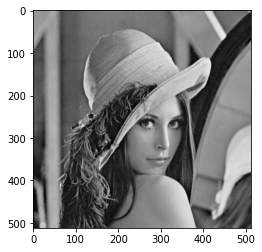

In [18]:
img = mpimg.imread("./inputs/lena.jpg")
plt.imshow(img)
plt.set_cmap("gray")
plt.show()

# 2.2

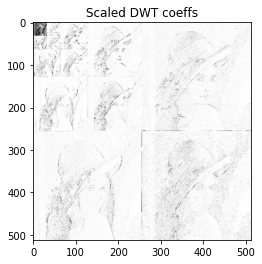

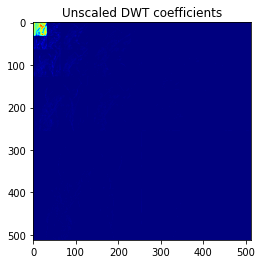

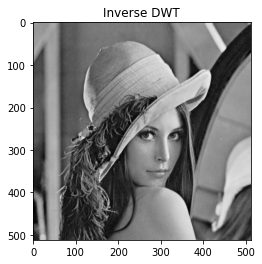

In [25]:
wav = "db3"
NLEV = 4
filter_bank = pywt.Wavelet(wav)
coeffs = pywt.wavedec2(img, filter_bank, mode="per", level=NLEV)
arr = wtt.coeffs_to_array(coeffs)
wtt.wtView(coeffs, "Scaled DWT coeffs")

plt.figure()
plt.imshow(np.abs(arr/arr.max()))
plt.set_cmap("jet")
plt.title("Unscaled DWT coefficients")
plt.show()

decoded = pywt.waverec2(coeffs, filter_bank, mode="per")

plt.imshow(np.uint8(decoded))
plt.title("Inverse DWT")
plt.set_cmap("gray")
plt.show()